# Model the data

In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
import pandas as pd
from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import math

In [2]:
%matplotlib inline

path='/Users/brianna/Documents/WL_DBdeets/'

## Build a model and study the results

In [3]:
# This example is written for a generic classifier model (here, using a RandomForestClassifier)

### Classifier

In [4]:
features = ['NumberSignedUpFromCompany_i_log',
          'MeetingsTotalWeek0_i_log',
          'PortionOfOrganizerWeek0_i_log',
          'added_meetingWeek0_i_log',
          'added_agenda_itemWeek0_i_log',
          'assigned_action_itemWeek0_i_log']
prediction = 'RetentionStatus2Levels'
#prediction = 'RetentionStatus'
classifier = RandomForestClassifier(n_estimators=1000, max_depth=20, min_samples_leaf=5)

# Read the data

In [5]:
modelData = pd.read_csv(path+'06_DataFinal.csv')

# Remove the upper numbers for these two variables where the slope starts to flatten out.
modelData.loc[modelData.NumberSignedUpFromCompany_i_log>math.log(30),'NumberSignedUpFromCompany_i_log']=None
modelData.loc[modelData.MeetingsTotalWeek0_i_log>math.log(20),'MeetingsTotalWeek0_i_log']=None


In [6]:
# Remove all rows with null values and see how many rows you have left.
columns = features[:]
columns.append(prediction)
print('Columns remaining after rows with NA\'s removed: '+str(len(modelData.dropna(subset=columns))))
modelData=modelData.dropna(subset=columns)
modelData[columns].head()

Columns remaining after rows with NA's removed: 6792


,NumberSignedUpFromCompany_i_log,MeetingsTotalWeek0_i_log,PortionOfOrganizerWeek0_i_log,added_meetingWeek0_i_log,added_agenda_itemWeek0_i_log,assigned_action_itemWeek0_i_log,RetentionStatus2Levels
0,2.197225,1.609438,0.000000,0.000000,0.000000,0.000000,1
1,2.197225,1.945910,0.154151,0.000000,0.000000,0.000000,0
2,2.197225,1.098612,0.000000,0.693147,1.386294,0.000000,0
3,2.197225,2.397895,0.000000,0.693147,2.564949,1.851915,1
5,2.197225,1.098612,0.000000,0.000000,0.000000,1.851915,0


In [7]:
# test_size = 20% of data for testing
X_train, X_test, Y_train, Y_test = train_test_split(modelData[features], modelData[prediction].values, test_size=0.20)
train = len(X_train)/float(len(modelData))
test = len(X_test)/float(len(modelData))
print "The model data have been split into train data ({train:.2%}) and test data ({test:.2%})".format(train=train, test=test)

The model data have been split into train data (79.99%) and test data (20.01%)


In [8]:
classifier.verbose = True
classifier.n_jobs = -1 # do as many jobs as there's room for on the computer
classifier.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.7s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)

In [9]:
# Predictions:
Y_pred = classifier.predict(X_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.6s finished


In [10]:
# Probabilities:
Y_proba = classifier.predict_proba(X_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.6s finished


### Scores

Definitions:

- *True Positives* are those which are labeled ``1`` which are actually ``1``
- *False Positives* are those which are labeled ``1`` which are actually ``0``
- *True Negatives* are those which are labeled ``0`` which are actually ``0``
- *False Negatives* are those which are labeled ``0`` which are actually ``1``


Meaning of the different scores:

$$ {\rm accuracy} \equiv \frac{\rm correct~labels}{\rm total~samples} $$

$$ {\rm precision} \equiv \frac{\rm true~positives}{\rm true~positives + false~positives} $$

$$ {\rm recall} \equiv \frac{\rm true~positives}{\rm true~positives + false~negatives} $$

$$ F_1 \equiv 2 \frac{\rm precision \cdot recall}{\rm precision + recall} $$

The **accuracy**, **precision**, **recall**, and **f1-score** all range from 0 to 1, with 1 being optimal.

In [11]:
classifier_score = classifier.score(X_test, Y_test) # same as accuracy in random forest
print classifier_score

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished


0.76821192053


In [12]:
classifier_accuracy_score = accuracy_score(Y_test, Y_pred)
print classifier_accuracy_score

0.76821192053


In [13]:
classifier_precision_score = precision_score(Y_test, Y_pred, average="weighted")
print classifier_precision_score

0.4


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


In [14]:
classifier_recall_score = recall_score(Y_test, Y_pred, average="weighted")
print classifier_recall_score

0.0588235294118


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


In [15]:
classifier_f1_score = f1_score(Y_test, Y_pred, average="weighted")
print classifier_f1_score

0.102564102564


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


In [16]:
#classifier_classification_report = classification_report(Y_test, Y_pred, target_names=classifierLabels.values())
classifier_classification_report = classification_report(Y_test, Y_pred)
print(classifier_classification_report)

             precision    recall  f1-score   support

          0       0.78      0.97      0.87      1053
          1       0.40      0.06      0.10       306

avg / total       0.70      0.77      0.69      1359



### Feature importance

In [17]:
df = pd.DataFrame(columns = ['feature','importance'], index=range(len(features)))
if isinstance(classifier, RandomForestClassifier):
    i=0
    for (feature, importance) in zip(features, classifier.feature_importances_):
        print feature, importance
        df.feature[i] = feature
        df.importance[i] = importance
        i+=1

dfsort = df.sort(columns = ['importance'], ascending = False)
dfsort.head(10)

dfsort.to_csv(path+'RandomForestFeatureImportance.csv')

NumberSignedUpFromCompany_i_log 0.262624456054
MeetingsTotalWeek0_i_log 0.199377908595
PortionOfOrganizerWeek0_i_log 0.168216385102
added_meetingWeek0_i_log 0.125714448737
added_agenda_itemWeek0_i_log 0.177800813713
assigned_action_itemWeek0_i_log 0.0662659877993


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


### Plot Feature Importance

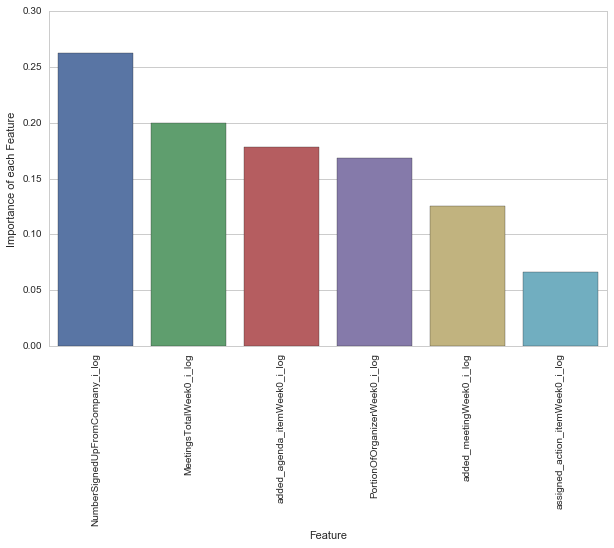

In [18]:
plt.figure(figsize=(10,6))

ax = sns.barplot(x='feature', y='importance', data=dfsort);
ax.set(xlabel='Feature', ylabel='Importance of each Feature')

for item in ax.get_xticklabels():
    item.set_rotation(90)

### Save information into a text file

In [20]:
fileName = "model.txt"
outputDirectory = path+"model_images"
outputPath = os.path.join(outputDirectory, fileName)
with open(outputPath, "w") as f:
    f.write("Classifier: {score:.2f}\n".format(score=classifier_score))
    f.write("Accuracy:   {score:.2f}\n".format(score=classifier_accuracy_score))
    f.write("Precision:  {score:.2f}\n".format(score=classifier_precision_score))
    f.write("Recall:     {score:.2f}\n".format(score=classifier_recall_score))
    f.write("F1:         {score:.2f}\n".format(score=classifier_f1_score))
    f.write("\n")
    f.write("Score {score}\n".format(score=classifier_classification_report))
    f.write("\n")
    if isinstance(classifier, RandomForestClassifier):
        f.write("Feature importance\n")
        for (feature, importance) in zip(features, classifier.feature_importances_):
            f.write("{feature}\t {importance:.2f}\n".format(feature=feature, importance=importance))
        f.write("\n")

### Confusion matrix

In [ ]:
# Make classifier labels
classifierLabels={0:'Churned', 1:'Retained for 3 Months'}

In [21]:
# Compute confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)

Confusion matrix, without normalization
[[1026   27]
 [ 288   18]]
Normalized confusion matrix
[[ 0.97  0.03]
 [ 0.94  0.06]]


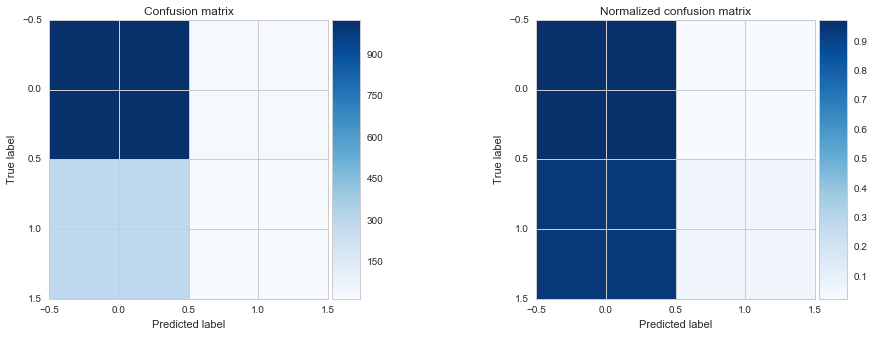

In [25]:
# Define a function to plot the confusion matrix:
def plot_confusion_matrix(ax, cm, title='Confusion matrix', cmap=plt.cm.Blues):
    # Plot the confusion matrix:
    image = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    # Plot the label on the ticks:
#     tick_marks = np.arange(len(classifierLabels))
#     ax.set_xticks(tick_marks, list(classifierLabels.values()))
#     ax.set_yticks(tick_marks, list(classifierLabels.values()))
#     locations = ax.set_xticks(tick_marks)
#     labels = ax.set_xticklabels(list(classifierLabels.values()))
#     for label in labels:
#         label.update({'rotation':90})
#     locations = ax.set_yticks(tick_marks)
# #     labels = ax.set_yticklabels(list(classifierLabels.values()))
    # Add colorbars:
    divider = make_axes_locatable(ax)
    colorbar_ax = divider.append_axes("right", size="10%", pad=0.05)
    colorbar = ax.figure.colorbar(image, cax=colorbar_ax)

# Create the figure:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# fig.suptitle("Model: {version}, {model}".format(version=versionLabel, model=modelLabel), fontsize=12)
for ax in axes:
    ax.set_aspect(1)

plot_confusion_matrix(axes[0], cm)
plot_confusion_matrix(axes[1], cm_normalized, title='Normalized confusion matrix')

# Save the figure:
# prefix = "-{version}".format(version=versionLabel)
fileName = "confusion-matrices.pdf"
outputDirectory = path+"model_images"
outputPath = os.path.join(outputDirectory, fileName)
fig.savefig(outputPath, bbox_inches="tight")